In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils, pickle, bz2
reload(mlutils)
%matplotlib inline

/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Observe AlexNet filters for the first two convolutional layers

Pretrained Network: https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/

Paper: [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

Source images: [Large Scale Visual Recognition Challenge 2012](http://www.image-net.org/challenges/LSVRC/2012/) [ImageNet](http://www.image-net.org)

Local file with weights from first two layers only



In [2]:
!ls -lash data/alexnet_conv1_conv2.pklz

1.4M -rw-r--r-- 1 user user 1.4M Mar 18 21:42 data/alexnet_conv1_conv2.pklz


In [3]:
alex_c12 = pickle.load(bz2.BZ2File("data/alexnet_conv1_conv2.pklz", "r"))
for k,(w,b) in alex_c12.iteritems():
    print k, b.shape, w.shape

conv2 (256,) (5, 5, 48, 256)
conv1 (96,) (11, 11, 3, 96)


we use for the moment only the first layer

(11, 11, 3, 96)


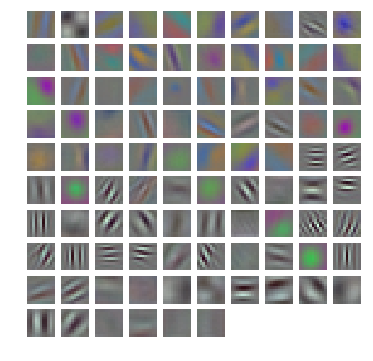

In [4]:
alex_w1 = alex_c12["conv1"][0]
print alex_w1.shape
mlutils.display_imgs(alex_w1)


### Vamos a usarlos como punto de partida para el entrenamiento de nuestra red

In [16]:
!wget https://s3.amazonaws.com/rlx/mini_cifar.h5

--2019-03-21 07:12:38--  https://s3.amazonaws.com/rlx/mini_cifar.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.16.227
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.16.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14803609 (14M) [binary/octet-stream]
Saving to: ‘mini_cifar.h5.2’

mini_cifar.h5.2     100%[===================>]  14.12M   117KB/s    in 2m 31s  

2019-03-21 07:15:10 (95.9 KB/s) - ‘mini_cifar.h5.2’ saved [14803609/14803609]



In [6]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

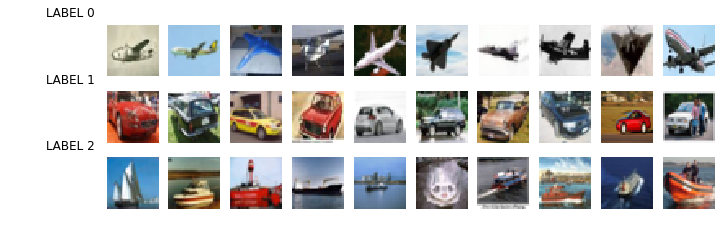

In [7]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
0    774
2    753
1    726
dtype: int64

distribution of test classes
2    272
1    248
0    231
dtype: int64


In [9]:
def get_conv_model_C(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [10]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}



In [11]:
num_classes = len(np.unique(y_cifar))
model = get_conv_model_C(num_classes)
model.summary()

using 3 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                976  

## Transfer learning!!!

- Importamos el valor de los filtros de primer nivel


In [12]:
w = model.get_weights()
for i in w:
    print i.shape

(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


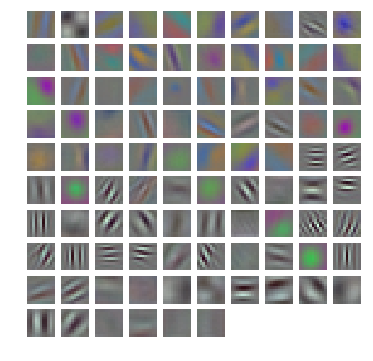

In [13]:
w[0] = alex_w1
mlutils.display_imgs(w[0])

In [14]:
model.set_weights(w)

In [17]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Train on 2253 samples, validate on 751 samples
Epoch 1/15
2253/2253 [==============================] - 12s 5ms/step - loss: 1.0344 - acc: 0.4700 - val_loss: 0.9165 - val_acc: 0.6165
Epoch 2/15
2253/2253 [==============================] - 10s 4ms/step - loss: 0.8992 - acc: 0.5659 - val_loss: 0.8535 - val_acc: 0.5979
Epoch 3/15
2253/2253 [==============================] - 10s 5ms/step - loss: 0.8375 - acc: 0.6232 - val_loss: 0.7468 - val_acc: 0.7017
Epoch 4/15
2253/2253 [==============================] - 10s 4ms/step - loss: 0.7728 - acc: 0.6551 - val_loss: 0.8096 - val_acc: 0.6458
Epoch 5/15
2253/2253 [==============================] - 10s 5ms/step - loss: 0.7219 - acc: 0.6844 - val_loss: 0.7723 - val_acc: 0.6578
Epoch 6/15
2253/2253 [==============================] - 12s 5ms/step - loss: 0.7029 - acc: 0.6942 - val_loss: 0.7016 - val_acc: 0.7190
Epoch 7/15
2253/2253 [==============================] - 11s 5ms/step - loss: 0.6782 - acc: 0.7208 - val_loss: 0.7139 - val_acc: 0.7164
Epoch 8/

{'acc': 0.73368841576354, 'loss': 0.7091151920361779}

Normalized confusion matrix
[[0.74458874 0.08658009 0.16883117]
 [0.10080645 0.80241935 0.09677419]
 [0.23897059 0.09926471 0.66176471]]


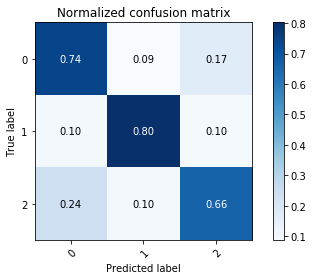

In [18]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

observa que los filtros de primer nivel cambiaron, pero muy poco

In [19]:
w0 = model.get_weights()[0]
np.mean(np.abs(w0-alex_w1))

0.021702627

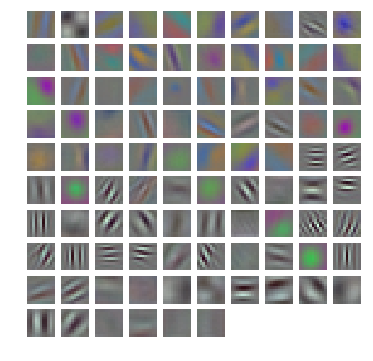

In [20]:
mlutils.display_imgs(w[0])

In [21]:
model.save("alexnet_finetuned_minicifar.model")

observe that you can also save separately the architecture

In [22]:
with open('alexnet_finetuned_minicifar.architecture.json', 'w') as f:
    f.write(model.to_json())

In [23]:
!ls -lash alexnet_finetuned_minicifar*

4.0K -rw-r--r-- 1 user user 3.8K Mar 21 07:24 alexnet_finetuned_minicifar.architecture.json
8.5M -rw-r--r-- 1 user user 8.5M Mar 21 07:24 alexnet_finetuned_minicifar.model


In [24]:
!head alexnet_finetuned_minicifar.architecture.json

{"class_name": "Model", "keras_version": "2.1.6-tf", "config": {"layers": [{"class_name": "InputLayer", "config": {"dtype": "float32", "batch_input_shape": [null, 32, 32, 3], "name": "input_1", "sparse": false}, "inbound_nodes": [], "name": "input_1"}, {"class_name": "Conv2D", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"dtype": "float32", "distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "conv2d", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "data_format": "channels_last", "padding": "valid", "strides": [1, 1], "dilation_rate": [1, 1], "kernel_regularizer": null, "filters": 96, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "use_bias": true, "activity_regularizer": null, "kernel_size": [11, 11]}, "inbound_nodes": [[["input_1", 0, 0, {}]]], "name": "conv2d"}, {"class_name": "MaxPooling2D", "config